In [1]:
import numpy as np
from numpy import ma
from scipy import stats, linalg, optimize
from matplotlib import ticker, cm
import matplotlib.pyplot as plt

# Methods

## Kennedy and O'Hagan Bayesian Model Calibration

The goal of calibration is to find a set of model parameter values that best reproduce the reality of experimental data. In 2001, statisticians Kennedy and O’Hagan \cite{KOH2001} developed a framework for Bayesian calibration of misspecified computer models. In this framework, an output $y$ from the physical system $\zeta$ is observed with measurement error $\epsilon$ for $n$ independent experimental controls $\mathbf{x} = [x_1,\dots, x_D ] \in \chi$, i.e., $y_i = \zeta(\mathbf{x}_i) + \epsilon_i, i=1,\dots, n$. The physical reality $\zeta(\mathbf{x})$ can be approximated by a mechanistic (computer) model $\eta(\mathbf{x},\boldsymbol{\theta})$ where $\boldsymbol{\theta} = [\theta_1,\dots,\theta_P]$ is a vector of physically meaningful parameters. There can also be a model discrepancy function that accounts for bias in the misspecified model. Therefore, the model for the experimental data is

$y = \eta(\mathbf{x}, \boldsymbol{\theta}) + \delta(\mathbf{x}) + \epsilon$,

where $\delta$ is the bias between the true processs $\zeta$ and the computer model $\eta$. The goal is to estimate the physically meaningful parameters $\boldsymbol{\theta}$ and those of the discrepancy function $\delta$, which is typically done in a Bayesian framework \cite{Higdon2004}.

## Gaussian Process Regression Semi-Parametric Regression

Consider the semi-parametric KOH model $y = \eta(\mathbf{x}_i, \boldsymbol{\theta}) + \delta(\mathbf{x}_i) + \epsilon_i$, where $\epsilon_1,\dots,\epsilon_n$ are independent normal random variables each with mean 0 and variance $\sigma_\epsilon^2$. Gaussian process (GP) regression is based on modeling $\delta$ as a Gaussian process with a mean function $m(\cdot)$ and a covariance function $K_\phi(\cdot,\cdot)$, where, for each $\phi$, $K_\phi$ is a real-valued function on $\chi \times \chi$ and $\phi \in \Phi$ is an unknown parameter vector. The function $\delta$ and the measurement error $\epsilon$ are assumed to be uncorrelated.

Under the GP distribution, $[\delta(\mathbf{x}_1),\dots,\delta(\mathbf{x}_n)] ^\intercal$ follows a multivariate distribution with a mean vector $\mathbf{0}$ and a covariance matrix based on

$\text{Cov}(\delta(\mathbf{x}_j), \delta(\mathbf{x}_k)) = K_\phi(\mathbf{x}_j,\mathbf{x}_k), \quad j,k = 1,\dots,n$.

It follows that the marginal distribution of $\mathbf{y}=[y_1,\dots,y_n]^\intercal$ is multivariate normal with mean vector $\boldsymbol{\eta}$ and a covariance matrix
$\Sigma_\phi + \sigma_\epsilon^2\mathbf{I}$, where $\mathbf{I}$ is the $n \times n$ identity matrix and $\Sigma_\phi$ is the $n\times n$ matrix with $(j,k)$th element given by the equation above.

For $\mathbf{x}^* \in \chi$, the conditional expected value of $\delta(\mathbf{x}^*)$ given the data is $\Sigma_\phi^*(\Sigma_\phi +\sigma_\epsilon^2\mathbf{I})^{-1}(\mathbf{y} - \boldsymbol{\eta})$ where $\Sigma_\phi^*$ is the $1 \times n$ matrix representing the covariance matrix of $\delta(\mathbf{x}^*)$.

## Functions

In [12]:
def mchlis_ment(x):
    ''' Ground truth Michaelis Menton model
    
    Arguments:
        x - inputs variables, float or np.array
    
    Returns:
        ζ - ground truth model evaluates at x, float or np.array
    '''
    
    ζ = 0.65*x/(1 + x/20)
    
    return ζ

def sq_exp(x1, x2, ϕ):
    '''Computes the covariance matrix with the squared exponential kernel function
    
    Agruments:
        x1 - co-variates, n1-dimensional np.array
        x2 - co-variates, n2-dimensional np.array
        ϕ - variance of model and length scale, 2x1 np.array
    
    Returns:
        Σ - covariance matrix, nxn np.array
        
    Additional Notes:
        The squared exponential kernel k(x1,x2) is computed by k(x1,x2) = σ^2 exp(-((x1-x2)/ψ)^2)
    '''
    
    # initialize covariance matrix
    n1 = len(x1)
    n2 = len(x2)
    Σ = np.zeros([n1,n2])
    
    # unpack hyperparameters
    σsq, ψ = ϕ
    
    # build covariance
    for i in range(n1):
        for j in range(n2):
            Σ[i,j] = σsq*np.exp(-((x1[i] - x2[j])/ψ)**2)
    
    return Σ

def gls_est(X, y, Σ):
    
    ''' Computes the generalized least sqaures (gls) estimator for data (X,y) and covariance Σ
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
    
    Returns:
        θ_hat - generalized least sqaures estimator, px1 np.array
        
    Additional Notes:
        The gls estimator is computed by θ_hat = (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    '''
    
    # Solve linear system z = Σy for z to get Σ^-1 y 
    z = np.linalg.solve(Σ, y)

    # Solve linear system W = ΣX for W to get Σ^-1 X 
    W = np.linalg.solve(Σ, X)
    
    # transpose matrix of regressors
    XT = np.transpose(X)

    # compute first term: X^T Σ^-1 X
    term1 = np.dot(XT, W)

    # compute second term: X^T Σ^-1 y
    term2 = np.dot(XT, z)

    # compute gls estimator (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    θ_hat = np.linalg.solve(term1, term2)

    return θ_hat


def ssr_cholesky(X, y, Σ, θ_hat):
    '''Computes the weighted sum of squared residuals (SSR) with Cholesky decomposition
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
        θ_hat - generalized least sqaures estimator, px1 np.array
    
    Returns:
        ssr - weighted sum of squared residuald
    
    Additional Notes:
        The sum of squared residuals in matrix notation is given by (y - Xθ_hat)^T Σ^-1 (y - Xθ_hat).
        Cholesky factorization of Σ yields Σ = L^T L.
    '''
    
    # compute residuals (y - Xθ_hat)
    resd =  y - np.dot(X, θ_hat)
    
    # Cholesky facorization, Σ = L^T L
    L, lower = linalg.cho_factor(Σ, lower = True)
    
    # Cholesky decomposition 1, r = L^-1 (y - Xθ_hat)
    r = linalg.solve(L, resd)
    
    # compute ssr
    ssr = np.dot(np.transpose(r), r)
    
    return ssr

def log_like(ω, X, y):
    '''Computes the negative log-likelihood of the a linear model assuming iid Normal observation error
    
    Arguments:
        ω - variance of discrepancy model σδsq, observation error  σϵsq, and lengthscale ψ, 3x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
    
    Returns:
        ℓ - log-likelihood, float
    '''
    
    # unpack parameters
    σδsq, σϵsq, ψ = ω
    
    # build discrepancy covariance
    Σ_δ = sq_exp(X[:,0], X[:,0], [σδsq, ψ])
    
    # build noise covariance
    Σ_ϵ = σϵsq*np.identity(len(X[:,0]))
    
    # build total covariance
    Σ = Σ_δ + Σ_ϵ

    # compute generalized least squares estimator
    θ_hat = gls_est(X, y, Σ)

    # compute weight sum of sqaured residuals with cholesky decomposition
    ssr = ssr_cholesky(X, y, Σ, θ_hat)
    
    # compute negtaive log-likelihood
    ℓ = 1/2*np.log(abs(np.linalg.det(Σ))) + 1/2*ssr
    
    return ℓ

def gp_predict(ω, X, y, x_star):
    
    ''' Predicts ground truth model ̂ζ with point estimates of GP
    
    Arguments:
        σsq - variance of discrepancy model σδsq and observation error  σϵsq, 2x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        x_star - predictors, npx1 np.array
    
    Returns:
        ζ_star - predicted ground truth model, npx1 np.array
    '''
    
    ## build covariance matrix
    
    # unpack parameters
    σδsq, σϵsq, ψ = ω
    
    # build observations covariance
    Σxx = sq_exp(X[:,0], X[:,0], [σδsq, ψ]) + σϵsq*np.identity(len(X[:,0]))
    
    # get ols estimate
    θ = gls_est(X, y, Σxx)
    
    # build off-diagonals
    Σxx_star = sq_exp(X[:,0], x_star, [σδsq, ψ])
    Σx_starx = np.transpose(Σxx_star)
    
    # build prediction variance
    Σx_starx_star = sq_exp(x_star, x_star, [σδsq,ψ])
    
    ## compute conditional mean
    
    # cholesky factorization
    L, lower = linalg.cho_factor(Σxx, True)
    
    # solve linear system 1
    α = linalg.solve(L, y - np.dot(X,θ))
    
    # solve linear system 2
    β = linalg.solve(np.transpose(L), α)
    
    # conditional mean
    μ_star = x_star*θ + np.dot(Σx_starx, β)
    
    ## compute conditional covariance
    
    # solve linear system
    γ = linalg.solve(L, Σxx_star)
    
    # compute covariance matrix
    Σ_star = Σx_starx_star - np.dot(np.transpose(γ), γ)
    
    return μ_star, Σ_star

## Synthetic data generation

In [13]:
## generate synthetic data

# set seed for reproducibility
np.random.seed(234)

# select independent variables
x = np.linspace(0, 10, 20)

# compute ground truth model
ζ = mchlis_ment(x)

# set ground truth variance of noise
σϵsq_tru = 0.1

# generate i.i.d. normal measurement error, ϵ_1 ,..., ϵ_n ~iid N(0,σϵsq_tru)
ϵ = stats.norm.rvs(loc = 0, scale = np.sqrt(σϵsq_tru), size = len(x))

# generate observations
y = ζ + ϵ

## Linear model misspecification and visualization

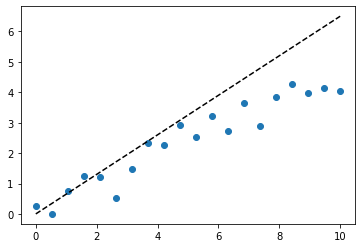

In [14]:
# choose parameter(s) of misspecified model η(x,θ)
θ = np.array([0.65])

# build nxp matrix of regressors
X = np.tile(x,len(θ)).reshape(len(x),len(θ))

# visualize misspecified model fit to data
plt.plot(x,y,'o')
plt.plot(x,np.dot(X,θ),'k--')

## Set bounds and initial values for parameter estimation

In [15]:
# variance of discrepancy
# lower bound
σδsq_lo = 0.1
# upper bound
σδsq_hi = 2
# inital guess
σδsq_0 = 1

## variance of noise
# lower bound
σϵsq_lo = 0.01
# upper bound
σϵsq_hi = 2
# inital guess
σϵsq_0 = 1

## length scale hyperparameter
# lower bound
ψ_lo = 0.1
# upper bound
ψ_hi = 4
# inital guess
ψ_0 = 2

## concatenate bounds and inital guesses
# bounds
bds = [(σδsq_lo, σδsq_hi),(σϵsq_lo, σϵsq_hi),(ψ_lo, ψ_hi)]
# inital guesses
ω_0 = [σδsq_0, σϵsq_0, ψ_0]

## Optimization

In [16]:
results = optimize.minimize(log_like, x0 = ω_0, args = (X, y), bounds = bds)
results

      fun: -4.9060314795288456
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.77818297e+01, -3.55271368e-07, -2.97609050e-02])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 64
      nit: 11
     njev: 16
   status: 0
  success: True
        x: array([0.1       , 0.22294022, 4.        ])

# Estimation and prediction

In [17]:
# unpack results of optimizations
ω = results.x

# predict outside training data
x_star = np.linspace(0,15)
μ, Σ = gp_predict(ω, X, y, x_star)

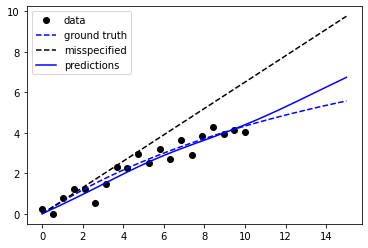

In [18]:
# plot data
plt.plot(x, y,'ko', label = 'data')

# plot ground truth model
plt.plot(x_star, mchlis_ment(x_star),'b--', label = 'ground truth')

# plot misspecified model
plt.plot(x_star,np.dot(x_star,0.65),'k--', label = 'misspecified')

# plot predictions
plt.plot(x_star, μ, 'b-', label = 'predictions' )
plt.legend()

In [19]:
σδsq = np.arange(σδsq_lo, σδsq_hi, 0.05)
σϵsq = np.arange(σϵsq_lo, σϵsq_hi, 0.05)
var1, var2 = np.meshgrid(σδsq, σϵsq)

In [20]:
ℓ = np.array([log_like([a,b,ω[2]], X ,y) for a, b in zip(np.ravel(var1), np.ravel(var2))]).reshape(var1.shape)

C:\Users\kilaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Log scale: values of z <= 0 have been masked
  


Text(0, 0.5, 'variance of noise, $\\sigma_\\epsilon^2$')

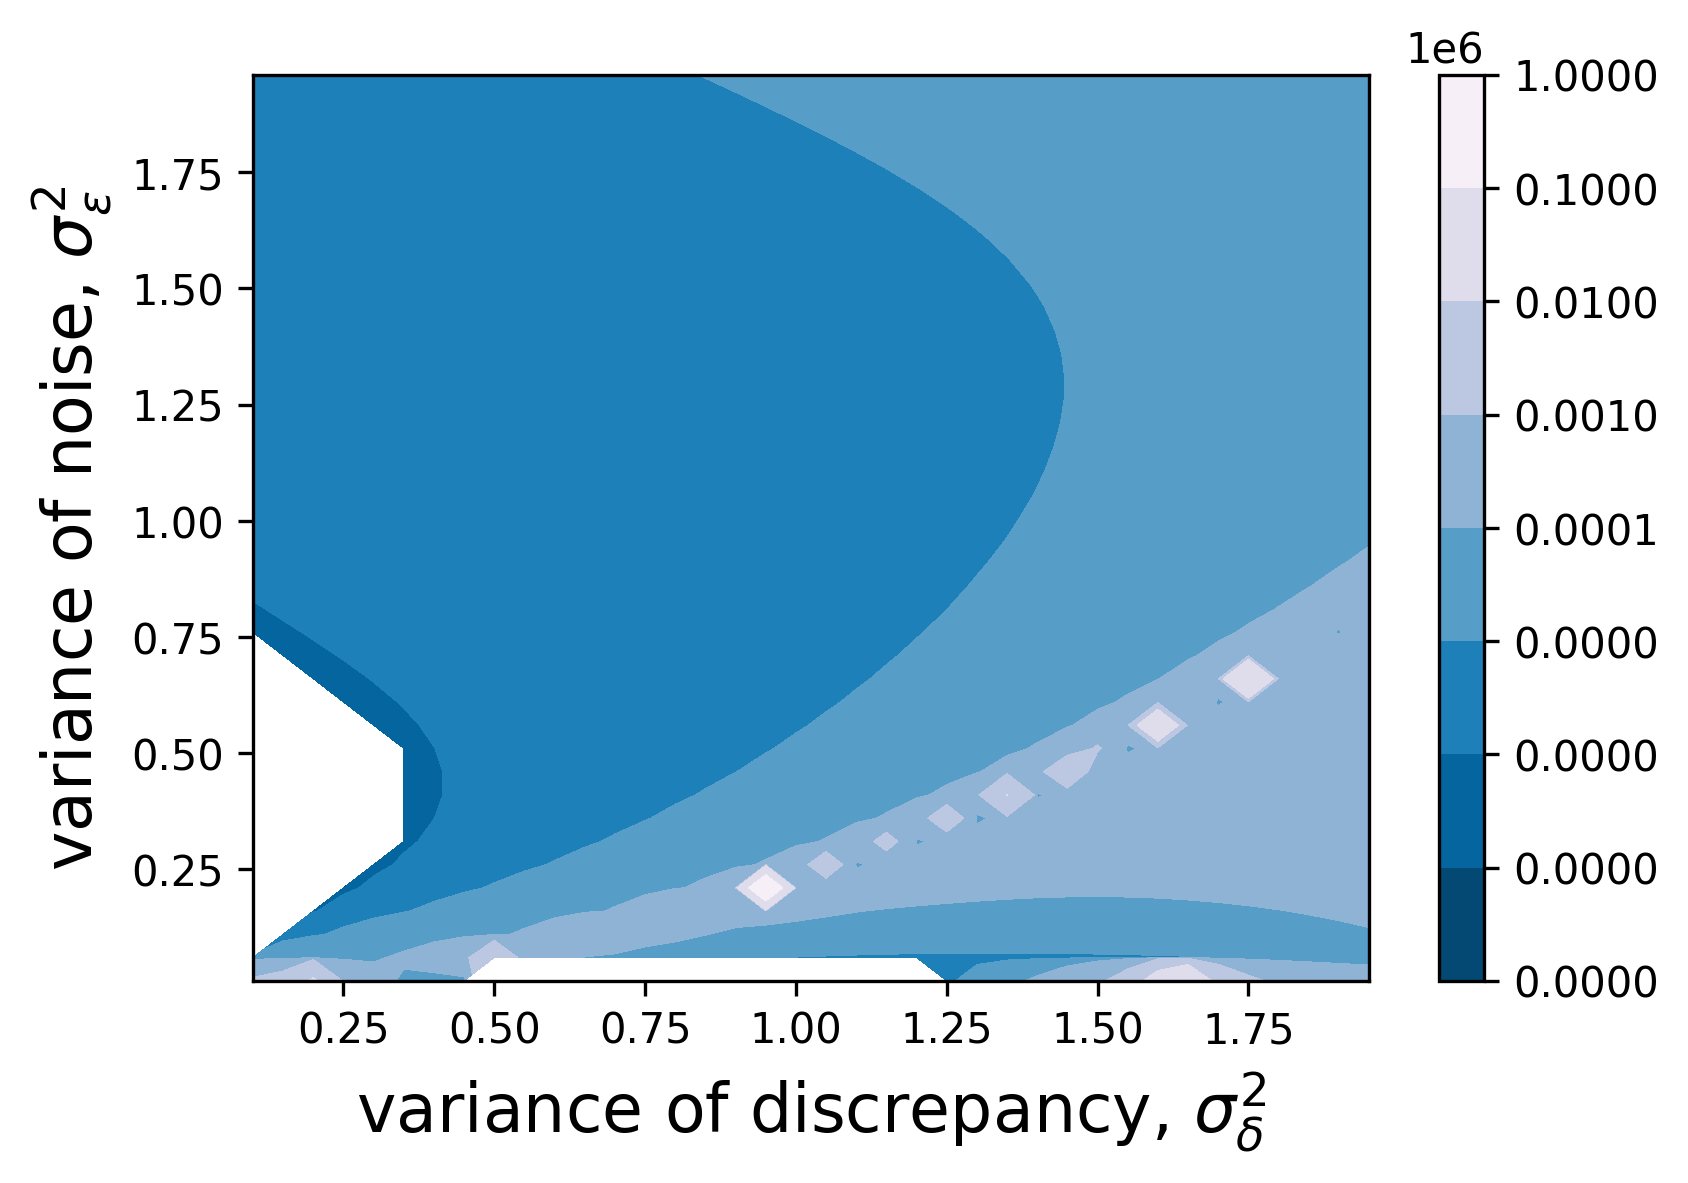

In [35]:
fig, ax = plt.subplots(dpi = 300)
cs = ax.contourf(var1, var2, ℓ,  locator = ticker.LogLocator(),  cmap = cm.PuBu_r)
cbar = fig.colorbar(cs)
ax.set_xlabel('variance of discrepancy, '+r'$\sigma_\delta^2$', fontsize = 16)
ax.set_ylabel('variance of noise, '+r'$\sigma_\epsilon^2$', fontsize = 16)

#ax.set_zlabel('Negative Log-Likelihood', fontsize = 16)
#ax.plot(ω[0], ω[1],log_like(ω,X,y),'k*', markersize = 8)
#fig.colorbar(cs ,label = 'Negative Log-Likelihood')